In [61]:
# Helper Scripts Run Notebook #

In [1]:
# Imports

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from torchvision import models, datasets, transforms
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights

from torchinfo import summary
from torch.optim.lr_scheduler import StepLR

from PIL import Image
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.metrics import (
    classification_report
    , confusion_matrix
    , ConfusionMatrixDisplay
)

from timeit import default_timer as timer
from tqdm import tqdm
import os
import random
import warnings
warnings.filterwarnings("ignore")

print("torch:", torch.__version__)

torch: 2.2.2


In [2]:
# Device selection (CUDA -> MPS -> CPU)
if torch.cuda.is_available():
    device = "cuda"  # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = "mps"   # Apple Silicon
else:
    device = "cpu"   # CPU fallback

print("device:", device)

device: mps


In [4]:
from helper_scripts.t0rch_h3lp3r_0x00 import (
    train_model
    , evaluate_model
    , evaluate_model_with_cm_params
    , list_test_images
    , show_image_prediction
    , plot_training_curves_seaborn
    , plot_training_curves
)

In [ ]:
# pip install kagglehub

In [5]:
# os.cpu_count()
int(os.cpu_count() *0.25)
# max(0, min(2, (os.cpu_count() or 2) // 2))

4

In [10]:
# Load the data from the drive:

train_dir = "./data/cars_image_dataset/train/"
test_dir = "./data/cars_image_dataset/test/"

train_dir, test_dir

('./data/cars_image_dataset/train/', './data/cars_image_dataset/test/')

In [11]:
# For init pretrained backbone - EfficientNet_B2 (*For small "toy" sets, EfficientNet_B2 and ConvNeXt-Tiny are both strong.) If acc/loss is not great, swap to ConvNeXt-Tiny by uncommenting the alt block below.

# --- Default: EfficientNet_B2 ---
weights = models.EfficientNet_B2_Weights.IMAGENET1K_V1
model = models.efficientnet_b2(weights=weights)
preprocess = weights.transforms()

In [12]:
weights, preprocess

(EfficientNet_B2_Weights.IMAGENET1K_V1,
 ImageClassification(
     crop_size=[288]
     resize_size=[288]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ))

In [13]:
# Use the preprocess transform for EfficientNet_B2 (preprocess)

num_workers=int(os.cpu_count() *0.25) 

train_dataset = datasets.ImageFolder(
    root=train_dir
    , transform=preprocess
)

test_dataset = datasets.ImageFolder(
    root=test_dir
    , transform=preprocess
)

train_loader = DataLoader(
    dataset=train_dataset
    , batch_size=32
    , shuffle=True
    , num_workers=num_workers # was 2, now trying 25% of cpu count (4)
)

test_loader = DataLoader(
    dataset=test_dataset
    , batch_size=32
    , shuffle=False
    , num_workers=num_workers # was 2, now trying 25% of cpu count (4)
)

len(train_dataset), len(test_dataset)

(3352, 813)

In [14]:
# Derive class names dynamically (no hardcoding)
class_names = train_dataset.classes
num_classes = len(class_names)
print("Number of classes:", num_classes)
print("Detected classes:", class_names)

Number of classes: 7
Detected classes: ['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']


In [15]:
num_classes, preprocess

(7,
 ImageClassification(
     crop_size=[288]
     resize_size=[288]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ))

In [31]:
### Take a peek at some of the data to get a feel for the shapes, batches, etc.

In [16]:
# get one batch
images, labels = next(iter(train_loader))

print("images.shape:", images.shape)   # e.g. torch.Size([32, 3, H, W])
print("labels.shape:", labels.shape)   # e.g. torch.Size([32])

images.shape: torch.Size([32, 3, 288, 288])
labels.shape: torch.Size([32])


In [17]:
import random
idx = random.randrange(len(train_dataset))
img, label = train_dataset[idx]
print("dataset sample shape:", img.shape)   # e.g. torch.Size([3, H, W])
print("label:", label)

dataset sample shape: torch.Size([3, 288, 288])
label: 1


In [29]:
# get a single img (random - by index int)

images, labels = next(iter(train_loader))
i = torch.randint(len(images), (1,)).item()   # random index in the batch
print(f"sample index: {i}")
print("single image shape:", images[i].shape)  # e.g. torch.Size([3, H, W])
print("single label:", labels[i].item())

sample index: 19
single image shape: torch.Size([3, 288, 288])
single label: 6


In [32]:
# Start building the model & hyperparams;

In [17]:
# UPDATED EffNetB2 --> w/ 2 add'l layers unfrozen;
# (Next option if not significant increase in metrix --> adjust preprocess: img size to 300 & batches of 16;)

model = model

for p in model.parameters():
    p.requires_grad = False

in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

# Unfreeze last 2 blocks
n_unfreeze = 2
total_blocks = len(model.features)
for i in range(total_blocks - n_unfreeze, total_blocks):
    for p in model.features[i].parameters():
        p.requires_grad = True

model = model.to(device)

# Optimizer with two groups
backbone_params = [p for m in model.features[total_blocks - n_unfreeze:] for p in m.parameters() if p.requires_grad]
head_params = list(model.classifier.parameters())

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW([
    {"params": backbone_params, "lr": 1e-4, "weight_decay": 1e-4}
    , {"params": head_params,     "lr": 5e-4, "weight_decay": 5e-5},
])

# Keep your StepLR or switch to cosine
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

In [18]:
# Running our training loop from 'train_model' function within helper script;

train_losses, train_accuracies = train_model(
    model=model
    , train_loader=train_loader
    , criterion=criterion
    , optimizer=optimizer
    , scheduler=scheduler
    , epochs=6
)

 17%|██████▌                                | 1/6 [01:05<05:29, 65.84s/it]

Epoch 1/6 | Loss: 1.2237 | Acc: 61.4558% | LR: 0.000100


 33%|█████████████                          | 2/6 [02:10<04:20, 65.14s/it]

Epoch 2/6 | Loss: 0.4831 | Acc: 87.5298% | LR: 0.000100


 50%|███████████████████▌                   | 3/6 [03:13<03:12, 64.05s/it]

Epoch 3/6 | Loss: 0.2510 | Acc: 93.1086% | LR: 0.000100


 67%|██████████████████████████             | 4/6 [04:15<02:06, 63.35s/it]

Epoch 4/6 | Loss: 0.1571 | Acc: 95.9129% | LR: 0.000100


 83%|████████████████████████████████▌      | 5/6 [05:20<01:03, 63.83s/it]

Epoch 5/6 | Loss: 0.1174 | Acc: 96.9570% | LR: 0.000080


100%|███████████████████████████████████████| 6/6 [06:24<00:00, 64.03s/it]

Epoch 6/6 | Loss: 0.0874 | Acc: 97.9714% | LR: 0.000080


In [19]:
import pandas as pd

# Build DataFrame from history (will code this in earlier in a later update;)
df_metrics = pd.DataFrame({
    "Epoch": range(1, len(train_losses) + 1)
    , "Train Loss": train_losses
    , "Train Accuracy": train_accuracies
})

df_metrics.tail(3)

Epoch  Train Loss  Train Accuracy
3      4    0.157076       95.912888
4      5    0.117422       96.957041
5      6    0.087361       97.971360

In [20]:
df_metrics['Train Loss'].min(), df_metrics['Train Accuracy'].max()

(0.0873608743874156, 97.97136038186157)

In [22]:
current_date = datetime.now().strftime("%Y-%m-%d")

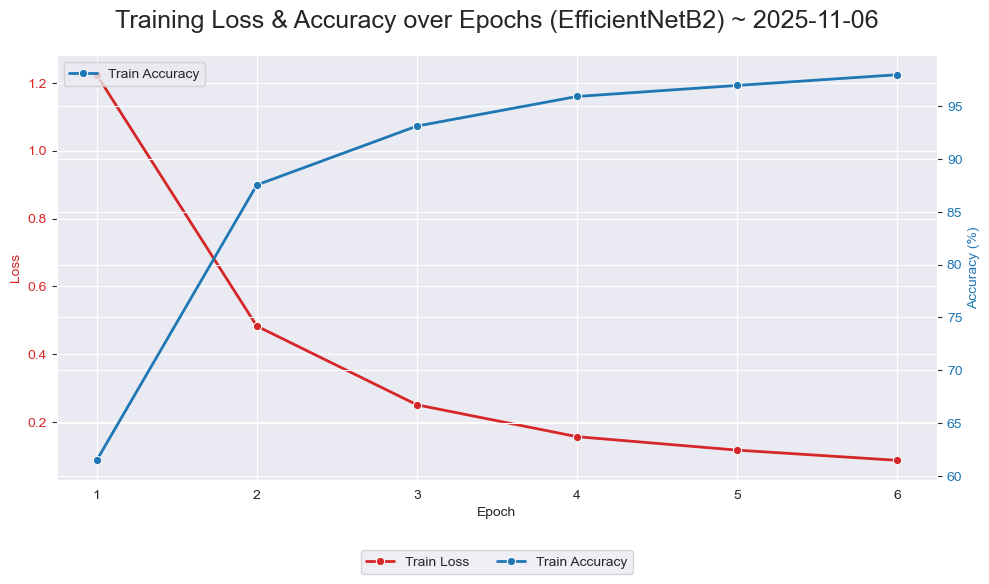

In [23]:
plot_training_curves_seaborn(
    df_metrics
    , x_col="Epoch"
    , loss_col="Train Loss"
    , acc_col="Train Accuracy"
    , title=f"Training Loss & Accuracy over Epochs (EfficientNetB2) ~ {current_date}"
)

In [24]:
# Running Test Loop on EfficientNet using our helper eval script (w/ built-in sklearn metrix options!)

test_acc, all_preds, all_labels = evaluate_model_with_cm_params(
    model=model
    , test_loader=test_loader
    , device=device
)

Test Accuracy: 95.0800%


In [ ]:
# We might be able to squeeze some better metrix out of this with a few more epochs!!!

In [25]:
%%time
### SECOND / FOLLOW-UP TRAINING RUN ("Retrain") ###

# EfficientNet_B2 Training Loop *** With tqdm progress bar AND stored loss/acc for plotting in next cell;

train_losses, train_accuracies = train_model(
    model=model
    , train_loader=train_loader
    , criterion=criterion
    , optimizer=optimizer
    , scheduler=scheduler
    , epochs=12
    , device=device
)

  8%|███▏                                  | 1/12 [01:00<11:08, 60.75s/it]

Epoch 1/12 | Loss: 0.0646 | Acc: 98.6277% | LR: 0.000080


 17%|██████▎                               | 2/12 [02:03<10:21, 62.17s/it]

Epoch 2/12 | Loss: 0.0496 | Acc: 98.9260% | LR: 0.000080


 25%|█████████▌                            | 3/12 [03:07<09:25, 62.79s/it]

Epoch 3/12 | Loss: 0.0500 | Acc: 99.0155% | LR: 0.000080


 33%|████████████▋                         | 4/12 [04:09<08:18, 62.33s/it]

Epoch 4/12 | Loss: 0.0405 | Acc: 99.0453% | LR: 0.000064


 42%|███████████████▊                      | 5/12 [05:09<07:11, 61.60s/it]

Epoch 5/12 | Loss: 0.0365 | Acc: 99.2840% | LR: 0.000064


 50%|███████████████████                   | 6/12 [06:09<06:06, 61.09s/it]

Epoch 6/12 | Loss: 0.0344 | Acc: 99.0453% | LR: 0.000064


 58%|██████████████████████▏               | 7/12 [07:09<05:03, 60.79s/it]

Epoch 7/12 | Loss: 0.0248 | Acc: 99.3437% | LR: 0.000064


 67%|█████████████████████████▎            | 8/12 [08:09<04:02, 60.63s/it]

Epoch 8/12 | Loss: 0.0278 | Acc: 99.4332% | LR: 0.000064


 75%|████████████████████████████▌         | 9/12 [09:10<03:01, 60.57s/it]

Epoch 9/12 | Loss: 0.0268 | Acc: 99.3138% | LR: 0.000051


 83%|██████████████████████████████▊      | 10/12 [10:10<02:01, 60.52s/it]

Epoch 10/12 | Loss: 0.0236 | Acc: 99.4928% | LR: 0.000051


 92%|█████████████████████████████████▉   | 11/12 [11:11<01:00, 60.50s/it]

Epoch 11/12 | Loss: 0.0249 | Acc: 99.3735% | LR: 0.000051


100%|█████████████████████████████████████| 12/12 [12:11<00:00, 60.98s/it]

Epoch 12/12 | Loss: 0.0169 | Acc: 99.7912% | LR: 0.000051
CPU times: user 3min 24s, sys: 1min 50s, total: 5min 14s
Wall time: 12min 11s


In [26]:
# Build another DataFrame from history (will code this in earlier in a later update;)

df_metrics_final = pd.DataFrame({
    "Epoch": range(1, len(train_losses) + 1)
    , "Train Loss": train_losses
    , "Train Accuracy": train_accuracies
})

df_metrics_final.tail(3)

Epoch  Train Loss  Train Accuracy
9      10    0.023577       99.492840
10     11    0.024925       99.373508
11     12    0.016867       99.791169

In [27]:
# Note - since it makes sense to append the epochs from both train loops rather than plotting separate append the two but tweek the latter to continue epochs chronologically(e.g., since df_metrics epochs are 1..6, df_metrics_final should be 7..15)

last_epoch = df_metrics['Epoch'].max()                # e.g. 6
df_metrics_final_shifted = df_metrics_final.copy()    # avoid mutating original
df_metrics_final_shifted['Epoch'] = df_metrics_final_shifted['Epoch'] + last_epoch

df_metrics_all = pd.concat([df_metrics, df_metrics_final_shifted], ignore_index=True)
df_metrics_all.tail(3)

Epoch  Train Loss  Train Accuracy
15     16    0.023577       99.492840
16     17    0.024925       99.373508
17     18    0.016867       99.791169

In [28]:
df_metrics_all['Train Loss'].min(), df_metrics_all['Train Accuracy'].max(), 

(0.016867018852667406, 99.791169451074)

In [35]:
current_date = datetime.now().strftime("%Y-%m-%d")
current_date

'2025-11-06'

In [30]:
# Plotting the overall training loss/acc curves w/ plotly express, for interactive:

plot_training_curves(
    df_metrics_all
    , x_col="Epoch"
    , loss_col="Train Loss"
    , acc_col="Train Accuracy"
    , title=f"Training Loss & Accuracy over Epochs (EfficientNetB2) ~ {current_date}"
)

In [31]:
# Running final test loop on EfficientNetB2 unfrozen model:

test_acc2, all_preds, all_labels = evaluate_model_with_cm_params(
    model=model
    , test_loader=test_loader
    , device=device
)

Test Accuracy: 95.9410%


In [ ]:
# Previous Test Accuracy (yesterday): 95.8180%

In [32]:
test_items, test_by_class = list_test_images(
    test_dir
    , class_names
)

print(f"Found {len(test_items)} test images across {len(class_names)} classes.")
for cls in class_names:
    print(f"  {cls:20s}: {len(test_by_class.get(cls, []))}")

Found 813 test images across 7 classes.
  Audi                : 199
  Hyundai Creta       : 67
  Mahindra Scorpio    : 75
  Rolls Royce         : 74
  Swift               : 102
  Tata Safari         : 106
  Toyota Innova       : 190


In [36]:
# Set up a 'saved_models' directory (if it doesnt already exist):
from datetime import datetime

# Derive model name automatically 
weights_str = str(weights) # 'EfficientNet_B2_Weights.IMAGENET1K_V1' 
# ^^^Need to update this in other scripts as I wont always be using 'eff'...

named_model = weights_str.split('_Weights')[0]  # 'EfficientNet_B2'

# Save directory setup
save_dir = "./saved_models/"
os.makedirs(save_dir, exist_ok=True)

# Add the current date to the filename
current_date_file = datetime.now().strftime("%Y%m%d") # Tweaked var name so this can have no '-';

# --- Build filename dynamically ---
model_save_path = os.path.join(
    save_dir
    , f"{named_model.lower()}_cars_7-class_{current_date_file}_unfrzn_lyrs_99-8trn_95-9tst.pth"
)
print(model_save_path)

./saved_models/efficientnet_b2_cars_7-class_20251106_unfrzn_lyrs_99-8trn_95-9tst.pth


In [37]:
# Save the trained model to .pth

# Save only the parameters
torch.save(model.state_dict(), model_save_path)
print(f"Model state_dict saved to: {model_save_path}")

Model state_dict saved to: ./saved_models/efficientnet_b2_cars_7-class_20251106_unfrzn_lyrs_99-8trn_95-9tst.pth


In [38]:
device

'mps'

In [68]:
from helper_scripts.t0rch_h3lp3r_0x00 import (
    train_model
    , evaluate_model
    , evaluate_model_with_cm_params
    , list_test_images
    , show_image_prediction
    , plot_training_curves_seaborn
    , plot_training_curves
)

In [73]:
# Leaving this in here for future recall;
# I had to update the helper script to fix an error and reimporting and rerunning still showed errors, despite changes, but found out - need to import and run 'importlib' to clear out the bad juju:

import importlib
from helper_scripts import t0rch_h3lp3r_0x00
importlib.reload(t0rch_h3lp3r_0x00)

Device: mps


<module 'helper_scripts.t0rch_h3lp3r_0x00' from '/Users/t4ng0_br4v0/Documents/_c0d3_l0c4l/PyTorch_tinkering/experimenting_code/helper_scripts/t0rch_h3lp3r_0x00.py'>

In [72]:
# Then I re-ran this:
from helper_scripts.t0rch_h3lp3r_0x00 import show_image_prediction

In [99]:
help(show_image_prediction)

Help on function show_image_prediction in module helper_scripts.t0rch_h3lp3r_0x00:

show_image_prediction(img_path, true_label=None, model=None, preprocess=None, class_names=None, device='mps')
    Displays an image, model prediction, and full class probability table.
    Optionally prints the provided true_label for quick correctness check.



In [75]:
test_items, test_by_class = list_test_images(
    test_dir
    , class_names
)

print(f"Found {len(test_items)} test images across {len(class_names)} classes.")
for cls in class_names:
    print(f"  {cls:20s}: {len(test_by_class.get(cls, []))}")

Found 813 test images across 7 classes.
  Audi                : 199
  Hyundai Creta       : 67
  Mahindra Scorpio    : 75
  Rolls Royce         : 74
  Swift               : 102
  Tata Safari         : 106
  Toyota Innova       : 190


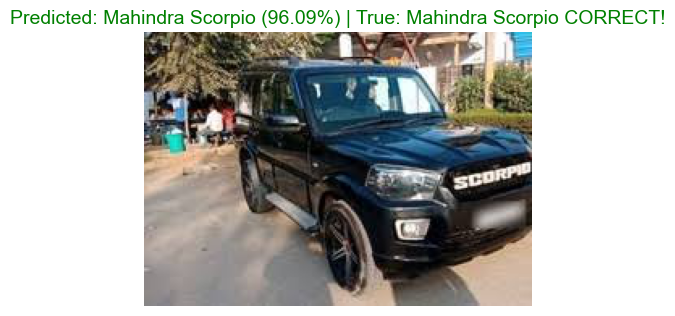

Class probabilities:
       Audi                :  0.1893%
       Hyundai Creta       :  2.2914%
* True Mahindra Scorpio    : 96.0922%
       Rolls Royce         :  0.0562%
       Swift               :  0.1031%
       Tata Safari         :  0.1377%
       Toyota Innova       :  1.1301%


In [76]:
# Show ONE truly random test image (from any class)

assert len(test_items) > 0, "No test images found."
rand_path, rand_true = random.choice(test_items)

show_image_prediction(
    img_path=rand_path
    , model=model
    , preprocess=preprocess
    , class_names=class_names
    , device=device
    , true_label=rand_true
)

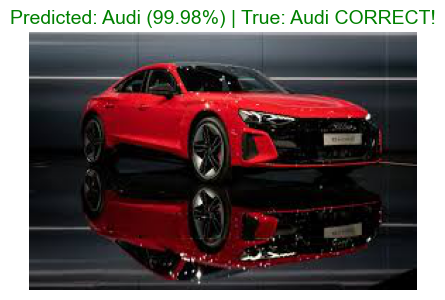

Class probabilities:
* True Audi                : 99.9850%
       Hyundai Creta       :  0.0001%
       Mahindra Scorpio    :  0.0001%
       Rolls Royce         :  0.0007%
       Swift               :  0.0001%
       Tata Safari         :  0.0000%
       Toyota Innova       :  0.0139%


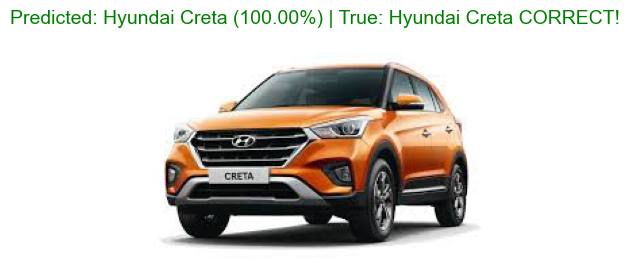

Class probabilities:
       Audi                :  0.0000%
* True Hyundai Creta       : 100.0000%
       Mahindra Scorpio    :  0.0000%
       Rolls Royce         :  0.0000%
       Swift               :  0.0000%
       Tata Safari         :  0.0000%
       Toyota Innova       :  0.0000%


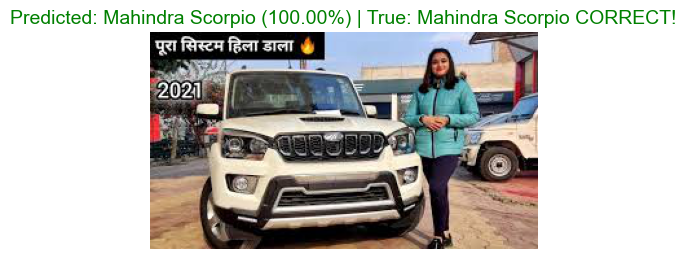

Class probabilities:
       Audi                :  0.0000%
       Hyundai Creta       :  0.0003%
* True Mahindra Scorpio    : 99.9996%
       Rolls Royce         :  0.0001%
       Swift               :  0.0000%
       Tata Safari         :  0.0000%
       Toyota Innova       :  0.0000%


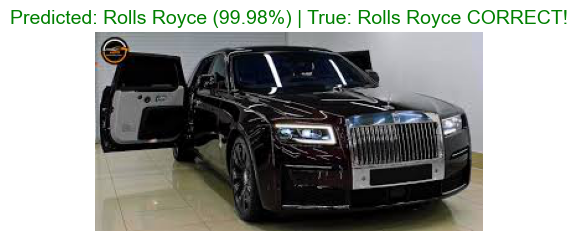

Class probabilities:
       Audi                :  0.0030%
       Hyundai Creta       :  0.0000%
       Mahindra Scorpio    :  0.0176%
* True Rolls Royce         : 99.9782%
       Swift               :  0.0000%
       Tata Safari         :  0.0000%
       Toyota Innova       :  0.0011%


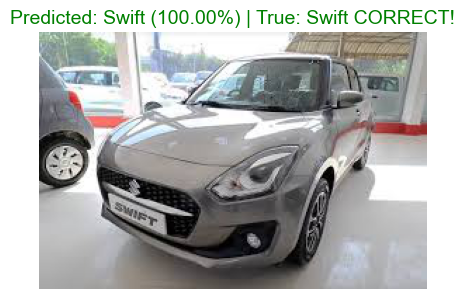

Class probabilities:
       Audi                :  0.0001%
       Hyundai Creta       :  0.0006%
       Mahindra Scorpio    :  0.0003%
       Rolls Royce         :  0.0000%
* True Swift               : 99.9952%
       Tata Safari         :  0.0039%
       Toyota Innova       :  0.0000%


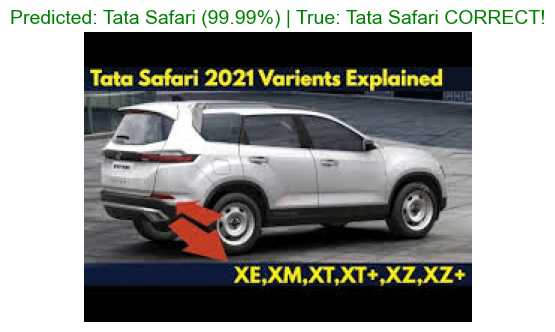

Class probabilities:
       Audi                :  0.0000%
       Hyundai Creta       :  0.0054%
       Mahindra Scorpio    :  0.0000%
       Rolls Royce         :  0.0000%
       Swift               :  0.0000%
* True Tata Safari         : 99.9945%
       Toyota Innova       :  0.0000%


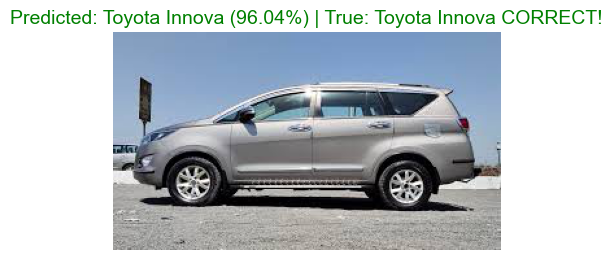

Class probabilities:
       Audi                :  0.0141%
       Hyundai Creta       :  0.4855%
       Mahindra Scorpio    :  0.0409%
       Rolls Royce         :  0.0002%
       Swift               :  2.3355%
       Tata Safari         :  1.0807%
* True Toyota Innova       : 96.0431%


In [81]:
# Show ONE random image PER CLASS (balanced peek)

for cls in class_names:
    candidates = test_by_class.get(cls, [])
    if not candidates:
        print(f"[skip] No images found for class: {cls}")
        continue
    img_path = random.choice(candidates)
    show_image_prediction(
        img_path=img_path   
        , model=model    
        , preprocess=preprocess    
        , class_names=class_names   
        , device=device    
        , true_label=cls
    )

### NEXT --> BUILD CONFUSION MATRIX (text & plot), classification_report; ###

In [84]:
test_acc, test_acc2

(95.079950799508, 95.9409594095941)

In [85]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


print(classification_report(all_labels, all_preds, digits=4))
confusion_matrix(all_labels, all_preds)

              precision    recall  f1-score   support

           0     0.9458    0.9648    0.9552       199
           1     0.9254    0.9254    0.9254        67
           2     0.9737    0.9867    0.9801        75
           3     0.9701    0.8784    0.9220        74
           4     0.9515    0.9608    0.9561       102
           5     0.9717    0.9717    0.9717       106
           6     0.9738    0.9789    0.9764       190

    accuracy                         0.9594       813
   macro avg     0.9589    0.9524    0.9553       813
weighted avg     0.9595    0.9594    0.9592       813



array([[192,   2,   0,   1,   2,   2,   0],
       [  2,  62,   1,   0,   1,   0,   1],
       [  0,   0,  74,   0,   1,   0,   0],
       [  7,   0,   1,  65,   0,   1,   0],
       [  1,   0,   0,   1,  98,   0,   2],
       [  0,   1,   0,   0,   0, 103,   2],
       [  1,   2,   0,   0,   1,   0, 186]])

<Figure size 1200x1200 with 0 Axes>

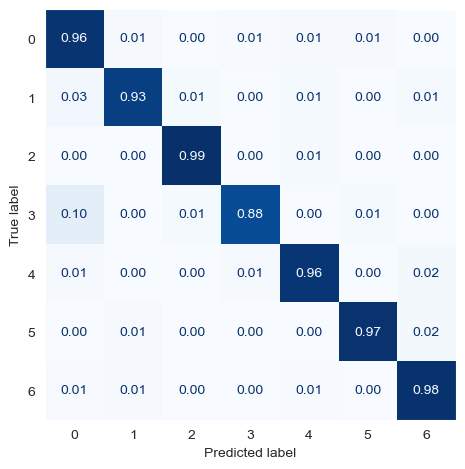

In [92]:
%matplotlib inline 

plt.figure(figsize=(12, 12)) 

disp = ConfusionMatrixDisplay.from_predictions(
    all_labels, all_preds
    , normalize="true", cmap="Blues", colorbar=False
)

plt.gca().grid(False)

# replace default annotations with two-decimal strings
for txt in plt.gca().texts: txt.set_text(f"{float(txt.get_text()):.2f}")
plt.tight_layout()
plt.show();

<Figure size 1200x1200 with 0 Axes>

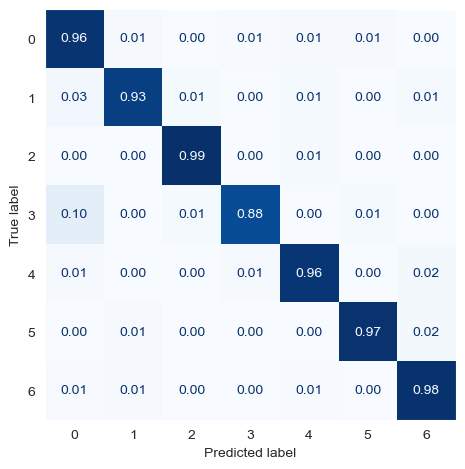

In [91]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(12, 12))
disp = ConfusionMatrixDisplay.from_predictions(
    all_labels, all_preds,
    normalize="true", cmap="Blues", colorbar=False
)

# Remove grid lines
plt.gca().grid(False)

# Replace default annotations with two-decimal strings
for txt in plt.gca().texts:
    txt.set_text(f"{float(txt.get_text()):.2f}")

plt.tight_layout()
plt.show()

In [52]:
from torchinfo import summary

In [96]:
# get a batch shape for summary
# images, labels = next(iter(train_loader))

input_shape = images.shape

In [97]:
input_shape

torch.Size([32, 3, 288, 288])

In [98]:
from torchinfo import summary
import torch

# Convert the input_shape to a tuple
input_size = input_shape

# Print a summary using torchinfo
summary(model=model,
        input_size=input_size  # Use the dynamically generated input_size
        , col_names=["input_size"
                     # , "output_size" # can have input_size or output_size (not both) due to size constraints
                     # ^ (cont.) I also find adjusting nb to '100% width' often breaks other things;
                     , "num_params"
                     , "trainable"
                    ]
        , col_width=20
        , row_settings=["var_names"]
       )

Layer (type (var_name))                                      Input Shape          Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 288, 288]    --                   Partial
├─Sequential (features)                                      [32, 3, 288, 288]    --                   Partial
│    └─Conv2dNormActivation (0)                              [32, 3, 288, 288]    --                   False
│    │    └─Conv2d (0)                                       [32, 3, 288, 288]    (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 144, 144]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 144, 144]   --                   --
│    └─Sequential (1)                                        [32, 32, 144, 144]   --                   False
│    │    └─MBConv (0)                                       [32, 32, 144, 144]   (1,448)              False
│    │    └─MB

In [ ]:
# Folder containing unseen images (these are images of pizza/ steak/ sushi randomly grabbed fm the internet;)
folder_path = "./data/unseen_cars/"

# Make a list of image files
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
image_files.sort()

# Ensure the model is in evaluation mode
model.eval()
model = model.to(device)

# Actual predix on unseen imgs:

predicted_labels = []
for img_name in image_files:
    img_path = os.path.join(folder_path, img_name)
    image = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        predicted_class = class_names[probabilities.argmax()]
        predicted_labels.append(predicted_class)

    print(f"{img_name} → Predicted: {predicted_class}")

In [ ]:
# Extract true labels from filenames
true_labels = [f.split("_")[0] for f in image_files]
print(true_labels)

In [ ]:
predicted_labels

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n")
print(classification_report(true_labels, predicted_labels))

print("Confusion Matrix:\n")
print(confusion_matrix(true_labels, predicted_labels))

In [ ]:
# ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(
    true_labels, predicted_labels
    , normalize="true", cmap="Blues"
)

# replace default annotations with two-decimal strings
for txt in plt.gca().texts: txt.set_text(f"{float(txt.get_text()):.2f}")
plt.show();

In [105]:
class_names

['Audi',
 'Hyundai Creta',
 'Mahindra Scorpio',
 'Rolls Royce',
 'Swift',
 'Tata Safari',
 'Toyota Innova']